# Asexual models

In [ ]:
!time pip install rdkit-pypi==2021.09.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 16.5 MB/s eta 0:00:00

real	0m17.484s
user	0m8.342s
sys	0m1.416s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sn
# import scipy as sp
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

import random
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


In [ ]:
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

In [ ]:
# rdkit seems to get stuck at certain parts when converting smiles into mols and
# and gives C++ coverter error. However when I split the dataset at these parts
# this seems to prevent the error.
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

len(compounds)

59530

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit'])
axl=dff
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

,mol,Hit
0,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
1,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
2,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
3,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
4,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
...,...,...
59525,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59526,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59527,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59528,"<img data-content=""rdkit/molecule"" src=""data:i...",No


# Molecular Morgan Fingerprint (MFP)

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit


def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

,mol,Hit,Target,Input
0,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
59525,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
59526,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
59527,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59528,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)

# Hyperparameter Tuning
Logistic regression does not really have any critical hyperparameters to tune.

Sometimes, you can see useful differences in performance or convergence with different solvers (solver).

Regularization (penalty) can sometimes be helpful.


Note: not all solvers support all regularization terms.

The C parameter controls the penality strength, which can also be effective.


---

Logistic Regression Hyperparameters we’ll be Looking at:

*   solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
*   penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
*   C in [100, 10, 1.0, 0.1, 0.01]
---
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python

In [ ]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset
#X = mfpdf  # we only take the first three features. iF THESE FEATURES ARE NOT NB CHANGE!!
#y = sxl["Target"]

# define models and parameters
model = LogisticRegression(class_weight={0:1,1:10})
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(Xt_train, Yt_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.791471 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791450 (0.004876) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791429 (0.004861) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791450 (0.004872) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.791443 (0.004861) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791471 (0.004880) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791429 (0.004910) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.791366 (0.004820) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791373 (0.004823) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791359 (0.004864) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.790470 (0.004928) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.790463 (0.004933) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.790736 (0.004927) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.783114 (0.005042) with: {'

In [ ]:
print(grid_result.cv_results_)

{'mean_fit_time': array([7.87802812, 2.47012528, 1.53379172, 7.74447984, 2.63440923,
       1.71797059, 7.79901268, 2.39204998, 1.68252176, 7.3658064 ,
       2.44114928, 1.65138309, 6.44353871, 2.02118356, 1.53872693]), 'std_fit_time': array([0.32577943, 0.28667097, 0.06212824, 0.38115275, 0.4435196 ,
       0.06153517, 0.40770666, 0.34838824, 0.06341256, 0.37556011,
       0.23674171, 0.05962037, 0.261474  , 0.1600962 , 0.03356135]), 'mean_score_time': array([0.01159559, 0.01092443, 0.00917019, 0.01160617, 0.01282239,
       0.00994577, 0.01286273, 0.01147063, 0.00957464, 0.01243148,
       0.01149524, 0.00996478, 0.01207611, 0.01099211, 0.00971169]), 'std_score_time': array([0.00187281, 0.00212215, 0.00077158, 0.0016505 , 0.00385534,
       0.00220892, 0.00168245, 0.00166528, 0.00039964, 0.00220918,
       0.0021526 , 0.00099139, 0.0028191 , 0.00175111, 0.0011082 ]), 'param_C': masked_array(data=[100, 100, 100, 10, 10, 10, 1.0, 1.0, 1.0, 0.1, 0.1,
                   0.1, 0.01, 0.01,

In [ ]:
clf_predict = grid_result.predict(Xt_test)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.791471 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791450 (0.004876) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791429 (0.004861) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791450 (0.004872) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.791443 (0.004861) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791471 (0.004880) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791429 (0.004910) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.791366 (0.004820) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791373 (0.004823) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791359 (0.004864) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.790470 (0.004928) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.790463 (0.004933) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.790736 (0.004927) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.783114 (0.005042) with: {'

In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7914707903616441


## Training

In [ ]:
###HPT
#Best: 0.855328 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(class_weight={0:1,1:10}, C= 10 ,penalty="l2",solver="lbfgs")

# fit the predictor and target
lrc.fit(Xt_train, Yt_train)

# predict
clf_predict = lrc.predict(Xt_test)# check performance

In [ ]:
lrc

LogisticRegression(C=10, class_weight={0: 1, 1: 10})

In [ ]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(lrc, 'asexualsLogisticRegressionFinalHPT_UMFP_model5005.pkl')

#Load Asexual screening test set

In [ ]:
import pandas as pd
df1= pd.read_csv("asexualsUntrainedTest.csv")
df1

,Unnamed: 0,mol,Hit,Smiles
0,51742,<rdkit.Chem.rdchem.Mol object at 0x7f71149bf680>,No,O=C(NCCCN1CCOCC1)C1CCCN(Cc2ccco2)C1
1,20279,<rdkit.Chem.rdchem.Mol object at 0x7f7114ed6180>,No,Cc1nocc1C(=O)N1CCCC2(CCN(c3cnn(C)c3)C2=O)C1
2,17729,<rdkit.Chem.rdchem.Mol object at 0x7f71219e38b0>,No,Cn1cncc1-c1nnc([C@H]2CCN(Cc3cccnc3)C2)o1
3,28545,<rdkit.Chem.rdchem.Mol object at 0x7f7114dc26c0>,No,CCn1nc(C)c2nc(C(C)C)nc(NCC(C)C)c21
4,24371,<rdkit.Chem.rdchem.Mol object at 0x7f7114f4b140>,No,CN(C)CC1(O)CCCN(Cc2ccccc2OCC(=O)N(C)C)C1
...,...,...,...,...
61024,72080,<rdkit.Chem.rdchem.Mol object at 0x7f7114740cf0>,No,N#Cc1cccc(NC(=O)NC2CCN(CCCCCNC(=O)/C=C/c3ccc(C...
61025,49244,<rdkit.Chem.rdchem.Mol object at 0x7f7114b4a340>,No,NC1(C(=O)NCC2CCCN(Cc3cccc4nonc34)C2)CCC1
61026,47413,<rdkit.Chem.rdchem.Mol object at 0x7f7114afbae0>,No,CNC(=O)C1CCCN(c2nc(-c3ccco3)nc3c2CCNCC3)C1
61027,73164,<rdkit.Chem.rdchem.Mol object at 0x7f711476eb20>,No,CC(Cc1ccc(OC2CCCCC2)cc1)NCC(O)c1cccc(Cl)c1.Cl


In [ ]:
compounds = []


for _, compound_key, smiles in df1[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl=dff
axl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f7113906500>,No,O=C(NCCCN1CCOCC1)C1CCCN(Cc2ccco2)C1
1,<rdkit.Chem.rdchem.Mol object at 0x7f7113906960>,No,Cc1nocc1C(=O)N1CCCC2(CCN(c3cnn(C)c3)C2=O)C1
2,<rdkit.Chem.rdchem.Mol object at 0x7f7113907680>,No,Cn1cncc1-c1nnc([C@H]2CCN(Cc3cccnc3)C2)o1
3,<rdkit.Chem.rdchem.Mol object at 0x7f71139061f0>,No,CCn1nc(C)c2nc(C(C)C)nc(NCC(C)C)c21
4,<rdkit.Chem.rdchem.Mol object at 0x7f7113906c00>,No,CN(C)CC1(O)CCCN(Cc2ccccc2OCC(=O)N(C)C)C1
...,...,...,...
61024,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2ef80>,No,N#Cc1cccc(NC(=O)NC2CCN(CCCCCNC(=O)/C=C/c3ccc(C...
61025,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2eff0>,No,NC1(C(=O)NCC2CCCN(Cc3cccc4nonc34)C2)CCC1
61026,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2f060>,No,CNC(=O)C1CCCN(c2nc(-c3ccco3)nc3c2CCNCC3)C1
61027,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2f0d0>,No,CC(Cc1ccc(OC2CCCCC2)cc1)NCC(O)c1cccc(Cl)c1.Cl


In [ ]:
## Convert test set mols into Mfp
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
axl["Hit"].value_counts()
def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

#axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

,mol,Hit,Smiles,Target
32262,<rdkit.Chem.rdchem.Mol object at 0x7f1c21ddcba0>,No,CCS(=O)(=O)N1CCC2(CC(=O)N(c3cccc(C)c3)C2)C1,0
22661,<rdkit.Chem.rdchem.Mol object at 0x7f1c23a3f610>,No,Cc1cc(C(=O)CN2C(=O)c3ccccc3CS2(=O)=O)c(C)[nH]1,0
28881,<rdkit.Chem.rdchem.Mol object at 0x7f1c21f3b300>,No,CCn1cc(CNC2CCN(c3cccc(Cl)c3)C2)cn1,0
26053,<rdkit.Chem.rdchem.Mol object at 0x7f1c21ec1310>,No,COc1cc(N2C[C@@H]3COC[C@]3(COCc3ccccn3)C2)ncn1,0
24909,<rdkit.Chem.rdchem.Mol object at 0x7f1c21e957e0>,No,COCc1nc(C(=O)N2CCN(c3nccc(OC)n3)CC2)cs1,0
...,...,...,...,...
82363,<rdkit.Chem.rdchem.Mol object at 0x7f1c21683df0>,No,CCCCNc1c(C(=O)OCC)c(C)nc2c1[nH]c1ccccc12,0
59195,<rdkit.Chem.rdchem.Mol object at 0x7f1c21a80b30>,No,COc1ccc(-c2c[nH]c(C3CC(=O)N(CC(C)C)C3)n2)cc1,0
62561,<rdkit.Chem.rdchem.Mol object at 0x7f1c218a9af0>,No,CN1CCN(C2CCN(CCOc3cccc(Cl)c3)CC2)C1=O,0
18045,<rdkit.Chem.rdchem.Mol object at 0x7f1c23bf86d0>,No,Cc1nc(CCNC(=O)NCC(c2ccco2)N(C)C)cs1,0


In [ ]:
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
Xt_test = df
Yt_test= axl["Target"]

0    58241
1     2788
Name: Target, dtype: int64


##LR

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

In [ ]:

lr_model = joblib.load('asexualsLogisticRegressionFinalHPT_UMFP_model5005.pkl')

In [ ]:

lrc_predict = lr_model.predict(Xt_test)
p= lrc_predict
p= pd.DataFrame(p)
print(p.value_counts())

1    30822
0    30207
dtype: int64


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,lrc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,lrc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,lrc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,lrc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,lrc_predict)
cm

Accuracy: 0.537826
Recall 0.969154
precision 0.087665
F1 score: 0.160785


array([[30121, 28120],
       [   86,  2702]])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, lrc_predict))
print('Accuracy score:',accuracy_score(Yt_test, lrc_predict))
print('F1 score:',f1_score(Yt_test, lrc_predict))

ROCAUC score: 0.7431660674685804
Accuracy score: 0.5378262793098363
F1 score: 0.16078548051175245


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, lrc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, lrc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, lrc_predict)
print(matrix)

Cohens kappa: 0.084040
ROC AUC: 0.743166
[[30121 28120]
 [   86  2702]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

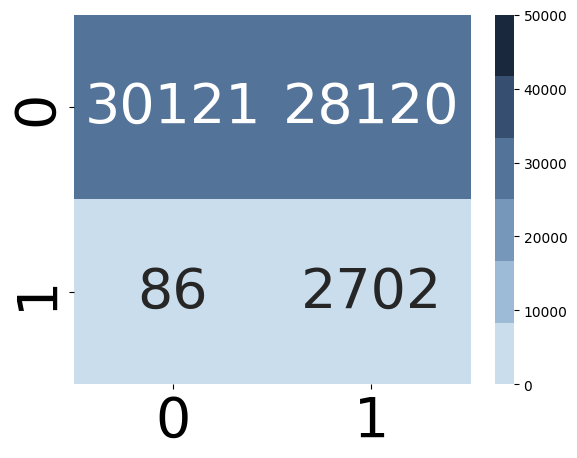

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
cm=[[30121 ,28120],
 [   86 , 2702]]
fig, ax = plt.subplots()
ax.tick_params(labelsize=40)
#ax.legend(markerscale=15)
sns.heatmap(cm, cmap=sns.cubehelix_palette(start=-.19,rot=-0.05), annot=True,annot_kws={"size": 40}, fmt='d',vmin=0, vmax=50000)# font size
plt.savefig('ABS_LR_UB_testMat.png',dpi=300, bbox_inches='tight')
from google.colab import files
files.download("ABS_LR_UB_testMat.png")

In [ ]:
print(f"Test Set: {len(Xt_test)}")
print(Yt_test.value_counts())
print(matrix)

Test Set: 61029
0    58241
1     2788
Name: Target, dtype: int64
[[30121 28120]
 [   86  2702]]


# Dual active models

In [ ]:
!time pip install rdkit-pypi==2021.09.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.2 MB/s eta 0:00:00

real	0m14.603s
user	0m8.286s
sys	0m0.924s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [ ]:
############################################Sexual data
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

# Molecular Morgan Fingerprint (MFP)

,Smiles,S_Hit,Target,ROMol,Input
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes,1,,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No,0,,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No,0,,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."

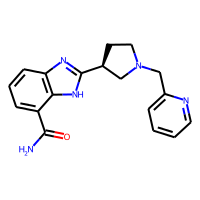
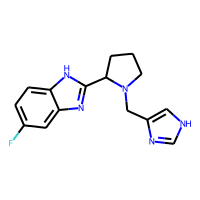
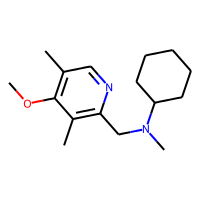
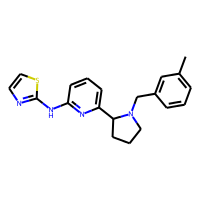
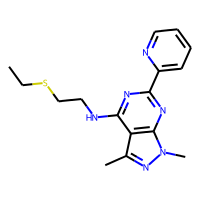
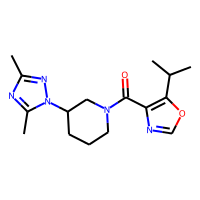
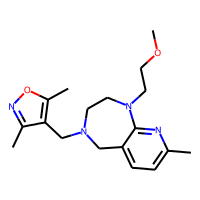
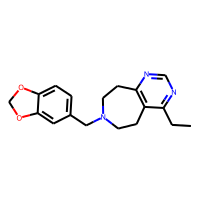
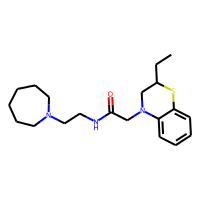
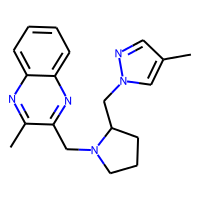

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
mfp= []
mfp = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

# Hyperparameter Tuning
Logistic regression does not really have any critical hyperparameters to tune.

Sometimes, you can see useful differences in performance or convergence with different solvers (solver).

Regularization (penalty) can sometimes be helpful.


Note: not all solvers support all regularization terms.

The C parameter controls the penality strength, which can also be effective.


---

Logistic Regression Hyperparameters we’ll be Looking at:

*   solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
*   penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
*   C in [100, 10, 1.0, 0.1, 0.01]
---
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python

In [ ]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset
#X = mfpdf  # we only take the first three features. iF THESE FEATURES ARE NOT NB CHANGE!!
#y = sxl["Target"]

# define models and parameters
model = LogisticRegression(class_weight={0:1,1:10})
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(Xt_train, Yt_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.938659 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.938153 (0.007252) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.938659 (0.007175) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.938195 (0.007379) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.937732 (0.006996) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.938533 (0.006618) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937859 (0.007147) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.937226 (0.008730) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937184 (0.008741) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937015 (0.008753) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.937479 (0.008385) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937436 (0.008411) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937479 (0.008646) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.934950 (0.008467) with: {

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(grid_result.cv_results_)

{'mean_fit_time': array([8.25375208, 1.14005439, 1.72926243, 4.04077965, 1.1430246 ,
       0.68578136, 2.63294732, 1.18991761, 0.4198914 , 1.79234302,
       0.79535916, 0.29386566, 1.31236455, 0.43163718, 0.19182435]), 'std_fit_time': array([1.08261252, 0.03913825, 0.38979681, 0.32052183, 0.03972107,
       0.04172282, 0.28694032, 0.18200167, 0.04348088, 0.11547809,
       0.07313127, 0.0263213 , 0.06341449, 0.01956217, 0.00902795]), 'mean_score_time': array([0.01339532, 0.01137197, 0.00983666, 0.0119945 , 0.0109164 ,
       0.01055434, 0.01282081, 0.01272767, 0.01052293, 0.01226515,
       0.01162932, 0.00957666, 0.01144269, 0.01150693, 0.00958076]), 'std_score_time': array([0.00440725, 0.00076329, 0.00145794, 0.00211838, 0.00137232,
       0.00481303, 0.00281116, 0.00723756, 0.00232135, 0.00159692,
       0.00148517, 0.00098992, 0.00185904, 0.00210121, 0.00154938]), 'param_C': masked_array(data=[100, 100, 100, 10, 10, 10, 1.0, 1.0, 1.0, 0.1, 0.1,
                   0.1, 0.01, 0.01,

In [ ]:
clf_predict = grid_result.predict(Xt_test)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.938659 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.938153 (0.007252) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.938659 (0.007175) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.938195 (0.007379) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.937732 (0.006996) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.938533 (0.006618) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937859 (0.007147) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.937226 (0.008730) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937184 (0.008741) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937015 (0.008753) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.937479 (0.008385) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937436 (0.008411) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937479 (0.008646) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.934950 (0.008467) with: {

In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9386589770439328


## Training

In [ ]:
###HPT
#Best: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
#0.9386589770439328

###################################################################### Logistic Regression adjusting classweights (https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html)
from sklearn.linear_model import  LogisticRegression
lrc = LogisticRegression(class_weight={0:1,1:10}, C= 100 ,penalty="l2",solver="lbfgs",max_iter=300)

# fit the predictor and target
lrc.fit(Xt_train, Yt_train)

# predict
clf_predict = lrc.predict(Xt_test)# check performance

In [ ]:
lrc

LogisticRegression(C=100, class_weight={0: 1, 1: 10}, max_iter=300)

In [ ]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(lrc, 'sexualsLRFinalHPT_UMFP_model5005.pkl')

#Load sexual screening test set

In [ ]:
import pandas as pd
df1= pd.read_csv("sexualsUntrainedTest.csv")
df1

,Unnamed: 0,mol,S_Hit,Smiles
0,25658,<rdkit.Chem.rdchem.Mol object at 0x7fc9363b4c10>,No,Cn1cc(CN2CC[C@@H]3[C@@H](CCC(=O)N3CCc3c[nH]cn3...
1,39559,<rdkit.Chem.rdchem.Mol object at 0x7fc9362189e0>,No,CC1(C)CN=C(N2CCN(CC3CCOC3)CC2)S1
2,36544,<rdkit.Chem.rdchem.Mol object at 0x7fc936195770>,No,COCCC(=O)N1CCN(CC2CC2)c2ccccc21
3,58789,<rdkit.Chem.rdchem.Mol object at 0x7fc935d5bd80>,No,CC(CC(=O)O)CC(=O)Nc1sc2c(c1C(N)=O)CCc1ccccc1-2
4,15213,<rdkit.Chem.rdchem.Mol object at 0x7fc9365e8190>,No,Clc1ccccc1CN1CCc2nc(C3CCCCN3)ncc2C1
...,...,...,...,...
62370,50615,<rdkit.Chem.rdchem.Mol object at 0x7fc935ffa1f0>,No,CC[C@@H](c1ccccc1)n1c(C2CC2)n[nH]c1=O
62371,57063,<rdkit.Chem.rdchem.Mol object at 0x7fc935f145f0>,No,CCn1ncc(S(=O)(=O)N[C@@H]2CC[C@@H](n3ccnc3C)[C@...
62372,19513,<rdkit.Chem.rdchem.Mol object at 0x7fc9364a6ff0>,No,O=C(Nc1ccc(F)cc1)C1CNCCN1C(=O)CC1CCCCC1
62373,41985,<rdkit.Chem.rdchem.Mol object at 0x7fc93607fa00>,No,CNC(=O)CN1CCC(NC(=O)CC(C)CCc2ccccc2)CC1


In [ ]:
compounds = []


for _, compound_key, smiles in df1[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
dff= pd.DataFrame (compounds, columns = ['mol', 'S_Hit', "Smiles"])
sxl=dff
sxl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c9e0>,No,Cn1cc(CN2CC[C@@H]3[C@@H](CCC(=O)N3CCc3c[nH]cn3...
1,<rdkit.Chem.rdchem.Mol object at 0x7f71c322d000>,No,CC1(C)CN=C(N2CCN(CC3CCOC3)CC2)S1
2,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c580>,No,COCCC(=O)N1CCN(CC2CC2)c2ccccc21
3,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c740>,No,CC(CC(=O)O)CC(=O)Nc1sc2c(c1C(N)=O)CCc1ccccc1-2
4,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c7b0>,No,Clc1ccccc1CN1CCc2nc(C3CCCCN3)ncc2C1
...,...,...,...
62370,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d49e0>,No,CC[C@@H](c1ccccc1)n1c(C2CC2)n[nH]c1=O
62371,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4a50>,No,CCn1ncc(S(=O)(=O)N[C@@H]2CC[C@@H](n3ccnc3C)[C@...
62372,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4ac0>,No,O=C(Nc1ccc(F)cc1)C1CNCCN1C(=O)CC1CCCCC1
62373,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4b30>,No,CNC(=O)CN1CCC(NC(=O)CC(C)CCc2ccccc2)CC1


In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
#PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
#sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["mol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

,mol,S_Hit,Smiles,Input,Target
33991,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3dc21f0>,No,CC(C)Oc1cccc2c1c(NC(=O)CN(C)C)nn2CC(F)(F)F,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0
68769,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34a7140>,Yes,CCc1c(-c2ccccc2)nc2c(c(C)c(C)n2CCN(C)C)c1N,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
29581,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3efc6d0>,No,Cc1cc(CN(CCCO)c2ccccc2)on1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
13351,<rdkit.Chem.rdchem.Mol object at 0x7fc3b422bed0>,No,CCCc1noc(-c2cn(CC(=O)N(CC)CC)nn2)n1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0
15429,<rdkit.Chem.rdchem.Mol object at 0x7fc3b4089460>,No,O=C(c1ccccn1)N1CCN(c2cnnc(N3CCCC3)c2)CC1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...
64363,<rdkit.Chem.rdchem.Mol object at 0x7fc3b35e57e0>,No,N#Cc1ccc(C(=O)N(Cc2ccncc2)C2CC2)cc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0
41138,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3ae3ae0>,No,CC1(C(N)=O)CN(CC2CCOCC2)CCO1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0
62527,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3596ab0>,No,N#Cc1ccc(NCCNc2ccc(C(F)(F)F)cn2)nc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
58523,<rdkit.Chem.rdchem.Mol object at 0x7fc3b36e00b0>,No,Cc1noc(CN(C)C(=O)CCn2cnc3ccccc32)n1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

In [ ]:
mfp= []
mfp = sxl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
Xt_test = df
Yt_test= sxl["Target"]

#LR

In [ ]:

lr_model = joblib.load('sexualsLRFinalHPT_UMFP_model5005.pkl')

In [ ]:
lrc_predict = lr_model.predict(Xt_test)
p= lrc_predict
p= pd.DataFrame(p)
print(p.value_counts())

0    58494
1     3881
dtype: int64


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,lrc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,lrc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,lrc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,lrc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,lrc_predict)
cm

Accuracy: 0.938437
Recall 0.675214
precision 0.020356
F1 score: 0.039520


array([[58456,  3802],
       [   38,    79]])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, lrc_predict))
print('Accuracy score:',accuracy_score(Yt_test, lrc_predict))
print('F1 score:',f1_score(Yt_test, lrc_predict))

ROCAUC score: 0.8070726090739584
Accuracy score: 0.938436873747495
F1 score: 0.03951975987993997


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, lrc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, lrc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, lrc_predict)
print(matrix)

Cohens kappa: 0.036009
ROC AUC: 0.807073
[[58456  3802]
 [   38    79]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

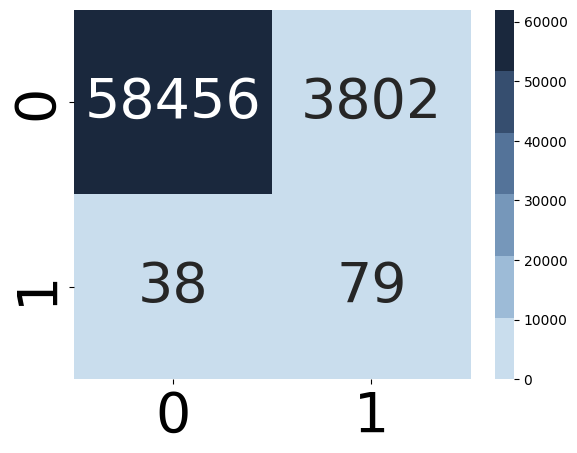

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
cm=[[58456 , 3802],
 [   38 ,   79]]
fig, ax = plt.subplots()
ax.tick_params(labelsize=40)
#ax.legend(markerscale=15)
sns.heatmap(cm, cmap=sns.cubehelix_palette(start=-.19,rot=-0.05), annot=True,annot_kws={"size": 40}, fmt='d',vmin=0, vmax=62000)# font size
plt.savefig('Dual_LR_UB_testMat.png',dpi=300, bbox_inches='tight')
from google.colab import files
files.download("Dual_LR_UB_testMat.png")